# Improved Energy Consumption Prediction in Austria

This notebook adds lag features, rolling statistics, holiday flags, and swaps to LightGBM for better forecasting performance.

## 1. Install dependencies

```bash
pip install pandas numpy scikit-learn joblib lightgbm dbrepo holidays matplotlib
```

In [27]:
import os
import pandas as pd
import numpy as np
from dbrepo.RestClient import RestClient
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import joblib
import holidays

## 2. Load the train & validation subsets from DBRepo

In [28]:
# initialize REST client
client = RestClient(
    endpoint=os.getenv("REST_API_ENDPOINT",
                       "https://test.dbrepo.tuwien.ac.at"),
    username=os.getenv("REST_API_USERNAME"),
    password=os.getenv("REST_API_PASSWORD")
)

# IDs
DATABASE_ID      = "d4ba48d9-7ed4-4b84-952f-407c1ca8942c"
TRAIN_SUBSET_ID  = "5e69a68a-243a-11f0-bf18-c60333c11641"
VALID_SUBSET_ID  = "46066f89-243a-11f0-8632-66164a21a937"

# fetch subsets
df_train = client.get_subset_data(
    database_id=DATABASE_ID, subset_id=TRAIN_SUBSET_ID, page=0, size=1000000000)
df_val = client.get_subset_data(
    database_id=DATABASE_ID, subset_id=VALID_SUBSET_ID, page=0, size=1000000000)

# parse & index
for df in (df_train, df_val):
    df['zeit_von'] = pd.to_datetime(df['zeit_von'])
    df.sort_values('zeit_von', inplace=True)
    df.set_index('zeit_von', inplace=True)
    df.rename(columns={'gesamtlast_mw': 'load'}, inplace=True)

df_train.head(), df_val.head()

(                                  zeit_bis    load
 zeit_von                                          
 2023-01-01 00:00:00  2023-01-01 00:15:00.0  5538.4
 2023-01-01 00:15:00  2023-01-01 00:30:00.0  5493.2
 2023-01-01 00:30:00  2023-01-01 00:45:00.0  5426.0
 2023-01-01 00:45:00  2023-01-01 01:00:00.0  5370.0
 2023-01-01 01:00:00  2023-01-01 01:15:00.0  5383.2,
                                   zeit_bis    load
 zeit_von                                          
 2024-07-01 00:00:00  2024-07-01 00:15:00.0  5281.6
 2024-07-01 00:15:00  2024-07-01 00:30:00.0  5194.8
 2024-07-01 00:30:00  2024-07-01 00:45:00.0  5098.4
 2024-07-01 00:45:00  2024-07-01 01:00:00.0  5030.8
 2024-07-01 01:00:00  2024-07-01 01:15:00.0  5012.4)

## 3. Feature Engineering

In [29]:
def add_time_series_features(df):
    # lag features
    df['lag_1']   = pd.to_numeric(df['load'].shift(1), errors='coerce')
    df['lag_96']  = pd.to_numeric(df['load'].shift(96), errors='coerce')
    df['lag_672'] = pd.to_numeric(df['load'].shift(672), errors='coerce')
    
    # rolling stats
    df['roll_1h_mean'] = pd.to_numeric(df['load'].shift(1), errors='coerce').rolling(window=4).mean()
    df['roll_1h_std']  = pd.to_numeric(df['load'].shift(1), errors='coerce').rolling(window=4).std()
    df['roll_1d_mean'] = pd.to_numeric(df['load'].shift(1), errors='coerce').rolling(window=96).mean()
    df['roll_1d_std']  = pd.to_numeric(df['load'].shift(1), errors='coerce').rolling(window=96).std()
    
    # calendar features
    df['hour']      = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month']     = df.index.month
    df['is_weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
    at_holidays = holidays.Austria(years=range(df.index.min().year, df.index.max().year+1))
    df['is_holiday'] = df.index.normalize().isin(at_holidays).astype(int)
    
    # ensure all features are correct dtype
    df['load'] = pd.to_numeric(df['load'], errors='coerce')
    
    return df.dropna()

# apply to both
df_train = add_time_series_features(df_train)
df_val   = add_time_series_features(df_val)

df_train.head()

/var/folders/tk/_ydpmd5979d19bklhywmytl00000gn/T/ipykernel_20472/124068841.py:19: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.normalize().isin(at_holidays).astype(int)
/var/folders/tk/_ydpmd5979d19bklhywmytl00000gn/T/ipykernel_20472/124068841.py:19: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.normalize().isin(at_holidays).astype(int)


,zeit_bis,load,lag_1,lag_96,lag_672,roll_1h_mean,roll_1h_std,roll_1d_mean,roll_1d_std,hour,dayofweek,month,is_weekend,is_holiday
zeit_von,,,,,,,,,,,,,,
2023-01-08 00:00:00,2023-01-08 00:15:00.0,5729.6,5698.8,5622.0,5538.4,5833.8,115.660884,6262.937500,719.119646,0,6,1,1,0
2023-01-08 00:15:00,2023-01-08 00:30:00.0,5648.4,5729.6,5527.6,5493.2,5773.5,76.760667,6264.058333,718.193411,0,6,1,1,0
2023-01-08 00:30:00,2023-01-08 00:45:00.0,5562.0,5648.4,5425.2,5426.0,5717.5,60.556860,6265.316667,716.994318,0,6,1,1,0
2023-01-08 00:45:00,2023-01-08 01:00:00.0,5479.6,5562.0,5324.0,5370.0,5659.7,73.229775,6266.741667,715.441302,0,6,1,1,0
2023-01-08 01:00:00,2023-01-08 01:15:00.0,5442.0,5479.6,5321.2,5383.2,5604.9,107.985863,6268.362500,713.456540,1,6,1,1,0


## 4. Prepare Datasets & Features

In [30]:
# feature list
features = [
    'hour','dayofweek','month',
    'lag_1','lag_96','lag_672',
    'roll_1h_mean','roll_1h_std','roll_1d_mean','roll_1d_std',
    'is_weekend','is_holiday'
]

# LightGBM datasets
lgb_train = lgb.Dataset(df_train[features], label=df_train['load'])
lgb_val   = lgb.Dataset(df_val[features],   label=df_val['load'], reference=lgb_train)

## 5. Train LightGBM Model

In [31]:
params = {
    'objective': 'regression',
    'metric': ['mae','rmse'],
    'verbosity': -1,
    'seed': 42
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(50)
    ]
)

Training until validation scores don't improve for 20 rounds
[50]	training's l1: 39.7229	training's rmse: 52.8471	valid_1's l1: 42.9448	valid_1's rmse: 57.7516
[100]	training's l1: 33.3237	training's rmse: 43.8237	valid_1's l1: 37.2181	valid_1's rmse: 49.7297
[150]	training's l1: 31.8797	training's rmse: 41.8439	valid_1's l1: 36.4141	valid_1's rmse: 48.6849
[200]	training's l1: 30.9691	training's rmse: 40.5677	valid_1's l1: 36.0337	valid_1's rmse: 48.2015
[250]	training's l1: 30.2045	training's rmse: 39.5131	valid_1's l1: 35.7533	valid_1's rmse: 47.9201
[300]	training's l1: 29.5857	training's rmse: 38.6895	valid_1's l1: 35.6232	valid_1's rmse: 47.7722
[350]	training's l1: 29.0342	training's rmse: 37.9371	valid_1's l1: 35.532	valid_1's rmse: 47.6944
[400]	training's l1: 28.5265	training's rmse: 37.2373	valid_1's l1: 35.4564	valid_1's rmse: 47.6111
Early stopping, best iteration is:
[426]	training's l1: 28.267	training's rmse: 36.8739	valid_1's l1: 35.4346	valid_1's rmse: 47.6002


## 6. Evaluate on Validation Set

In [32]:
# predictions and evaluation
y_pred = gbm.predict(df_val[features])
print('MAE:', mean_absolute_error(df_val['load'], y_pred))
print('RMSE:', mean_squared_error(df_val['load'], y_pred) ** 0.5)

MAE: 35.4345577648874
RMSE: 47.60016929195084


## 7. Save the Trained Model

In [33]:
# save model
joblib.dump(gbm, 'apg_model.pkl')

['apg_model.pkl']

## 8. Plot Graph

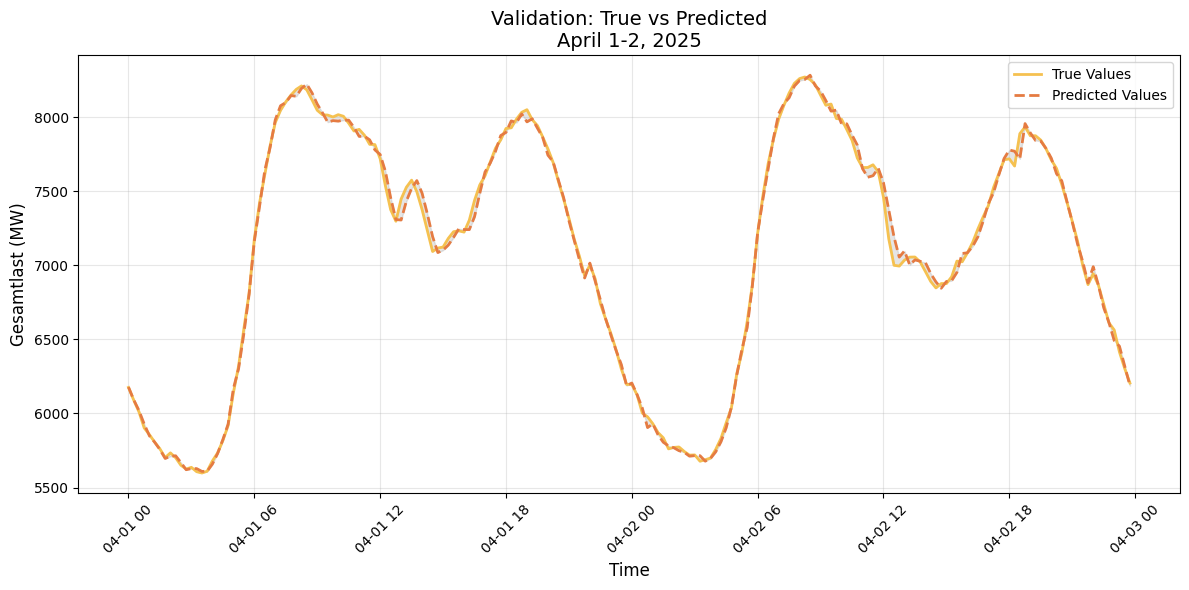

In [34]:
# Plot true vs predicted values for April 1-2, 2025
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for April 1-2, 2025
start_date = '2025-04-01'
end_date = '2025-04-02 23:59:59'
mask = (df_val.index >= start_date) & (df_val.index <= end_date)
plot_df = df_val[mask].copy()
plot_df['predicted'] = gbm.predict(plot_df[features])

# Create the visualization
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['load'],
         label='True Values', color='#f5c150', linewidth=2)
plt.plot(plot_df.index, plot_df['predicted'],
         label='Predicted Values', color='#e57b42', linewidth=2, linestyle='--')
plt.fill_between(
    plot_df.index, plot_df['load'], plot_df['predicted'], color='gray', alpha=0.2)

# Format the plot
plt.title('Validation: True vs Predicted\nApril 1-2, 2025', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Gesamtlast (MW)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H'))
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig('Validation_True_vs_Predicted.png', dpi=300, bbox_inches='tight')
plt.show()